# <center> 作业二 Food-11 </center>
by Hyr1sky_He

_为了提高任务效率，本ipynb中不再细化每个步骤的操作过程，仅记录重要思路及核心方法，Task题目解答将在实验报告中给出_

In [2]:
import numpy as np
import pandas as pd
import torch
import time
import os
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm.auto import tqdm
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load the train model
"""
model = classifier().to(device)
state_dict = torch.load('model.pth')
model.load_state_dict(state_dict)
model.eval()

print(model)
"""

"\nmodel = classifier().to(device)\nstate_dict = torch.load('model.pth')\nmodel.load_state_dict(state_dict)\nmodel.eval()\n\nprint(model)\n"

## 数据加载

In [3]:
# 读入数据
data_dir = Path('../Assignment2_dataset/food-11')
train_dir = data_dir / 'training'
val_dir = data_dir / 'validation'
test_dir = data_dir / 'testing'

def readfile(path,own_label):#后面的参数用来区分训练集和测试集
    image_dir = sorted(os.listdir(path)) #对path下的文件进行排序后输出
    x = np.zeros((len(image_dir),128,128,3),dtype=np.uint8) #初始化，用来保存训练数据
    y = np.zeros((len(image_dir)),dtype=np.uint8) #初始化，用来保存label
    for i,file in enumerate(image_dir): #循环，将图片信息保存到x,y
        # 读取image
        img = Image.open(os.path.join(path,file))
        # 将image Resize成(128, 128)
        x[i,:,:] = img.resize((128,128))
        if own_label: #此处来判断是训练还是测试，True为训练，False为测试
            y[i] = int(file.split("_")[0]) #如果是True,则给y赋值，文件名的第一个数
    if own_label:#有label，返回x,y
        return x,y
    else:#无label，返回x
        return x

## 关于Transform
[torchvision.transforms 常用方法解析（含图例代码以及参数解释）](https://blog.csdn.net/weixin_42426841/article/details/129903800)

In [7]:
# transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

batch_size = 128
# 采用分批次训练（加快参数更新速度），设置好我们的batch_size大小

In [6]:
# Load the dataset.
#分别读取训练、验证和测试的数据，保存到相应的变量里
train_x, train_y = readfile(train_dir, True)
print("Size of training data = {}".format(len(train_x)))
val_x ,val_y = readfile(val_dir, True)
print("Size of validation data = {}".format(len(val_x)))
test_x = readfile(test_dir, False)
print("Size of Testing data = {}".format(len(test_x)))

"""
train_set = DatasetFolder(train_dir, loader=lambda x: Image.open(x), extensions="jpg", transform=train_transform)
valid_set = DatasetFolder(val_dir, loader=lambda x: Image.open(x), extensions="jpg", transform=test_transform)
unlabeled_set = DatasetFolder(, loader=lambda x: Image.open(x), extensions="jpg", transform=train_transform)
test_set = DatasetFolder(test_dir, loader=lambda x: Image.open(x), extensions="jpg", transform=test_transform)
"""
# Construct data loaders.
"""
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
"""

Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347


'\ntrain_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)\nvalid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)\ntest_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)\n'

C:\Users\Hyr1sky\AppData\Local\Temp\ipykernel_27052\2470351709.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 5, i+1)


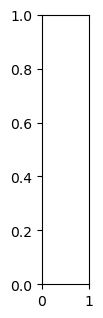

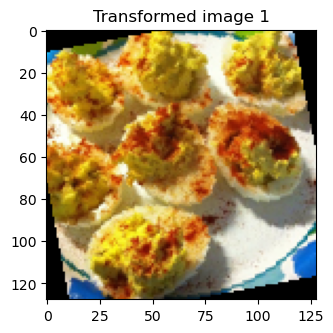

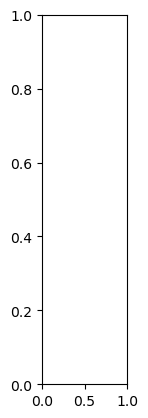

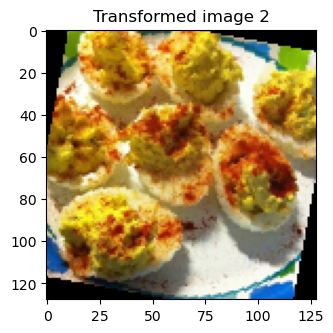

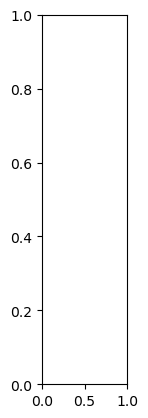

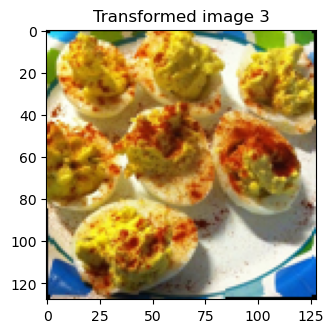

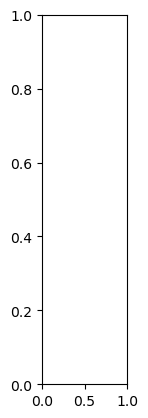

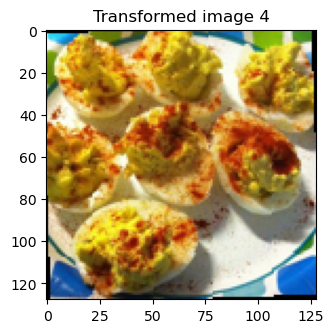

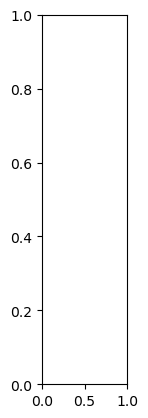

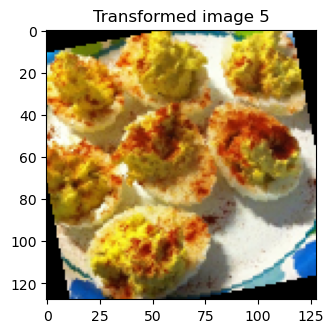

In [67]:
# 数据集类处理
class ImgDataset(Dataset):
    def __init__(self,x,y = None,transform = None):
        self.x = x
        self.y = y
        if y is not None: #label必须为长整形
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self,index):
        X = self.x[index]
        if self.transform is not None:#判断是否有图像变换
            X = self.transform(X) #有，则取变换后的X
        if self.y is not None: #判断是否有y(label)
            Y = self.y[index]
            return X,Y #有，则返回X,Y
        else:
            return X #无y(label),返回X

# 随机取出一张图片，显示原图和变换后的图片
idx = np.random.randint(0, len(train_x))
origin_img = train_x[idx]
plt.figure(figsize=(3.5, 3.5))
plt.title('Origin image')
plt.imshow(origin_img)

for i in range(5):
    img = train_transform(origin_img)
    plt.subplot(1, 5, i+1)
    plt.figure(figsize=(3.5, 3.5))
    plt.title(f"Transformed image {i + 1}")
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

train_set = ImgDataset(train_x,train_y,train_transform)
val_set = ImgDataset(val_x,val_y,test_transform)
test_set = ImgDataset(test_x,None,test_transform)

train_loader = DataLoader(train_set,batch_size = batch_size,shuffle = True)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle = False)
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle = False)

## 做一个小的数据切片来实验

In [ ]:
# 随机取出1000张训练集数据组成新的训练集
random_sample = np.random.randint(0, len(train_set), size=1000)
train_miniset = Subset(train_set, random_sample)
val_miniset = Subset(val_set, random_sample)
test_miniset = Subset(test_set, random_sample)

print("Size of mini training data = {}".format(len(train_miniset)))

In [4]:
# CNN
class CNN_baseline(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )

    def forward(self, x):
        #
        out = self.CNN(x)

        return out